In [6]:
from math import exp, sqrt
from random import random, seed
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sb
from numba import jit

In [36]:
# Define the Franke Fumction
def frankeFunction(x1,x2,sig2):
    noise = np.random.normal(0,sig2,x1.shape)
    term1 = 0.75*np.exp(-(0.25*(9*x1-2)**2) - 0.25*((9*x2-2)**2))
    term2 = 0.75*np.exp(-((9*x1+1)**2)/49.0 - 0.1*(9*x2+1))
    term3 = 0.5*np.exp(-(9*x1-7)**2/4.0 - 0.25*((9*x2-3)**2))
    term4 = -0.2*np.exp(-(9*x1-4)**2 - (9*x2-7)**2)
    return term1 + term2 + term3 + term4 + noise

# Create the data points in mesh grid form
def createDataPoints(n, sig2):
    x1 = np.arange(0, 1, 1/n)
    x2 = np.arange(0, 1, 1/n)
    x1_d, x2_d = np.meshgrid(x1,x2)
    y_d = frankeFunction(x1_d,x2_d,sig2)
    return x1_d, x2_d, y_d.ravel()

@jit
def createDesignMatrix(x1, x2, n=4):
    if len(x1.shape) > 1:
        x1 = np.ravel(x1)
        x2 = np.ravel(x2)

    N = len(x1)
    p = int((n+1)*(n+2)/2)
    X = np.ones((N,p))

    for i in range(1, n+1):
        q = int(i*(i+1)/2)
        for j in range(i+1):
            X[:,q+j] = (x1**(i-j))*(x2**j)
    return X

# Calculate the mean square error (MSE)
def MSE(y_data, y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

# Calculate the coefficient of determination (R2)
def R2(y_data, y_model):
    n = np.size(y_data)
    return 1 - np.sum((y_data-y_model)**2)/np.sum((y_data-(np.sum(y_data)/n))**2)

def Scale(X_train, X_test):
    XX = np.copy(X_test)
    if X_train.shape[1] > 1:
        scaler = StandardScaler()
        scaler.fit(X_train[:,1:])
        X_train[:,1:] = scaler.transform(X_train[:,1:])
        XX[:,1:] = scaler.transform(XX[:,1:])  
    return X_train, XX#, y_train[:, np.newaxis], y_test[:, np.newaxis]


# The stochastic gradient descent method
def SGD(X, y):
    theta_linreg = np.linalg.inv(X.T @ X) @ (X.T @ y)
    
def learning_schedule(t):
    return t0/(t+t1)

def momentumSGD(beta, n_epochs, numMiniBatch, samPerMini, eta, lmb):
    gamma = 0.9
    velocity = 0
    for epoch in range(n_epochs):
        for i in range(numMiniBatch):

            xi = X_train[i*samPerMini:(i+1)*samPerMini]
            yi = y_train[i*samPerMini:(i+1)*samPerMini]
            
            gradients = 2/samPerMini * (xi.T @ ((xi @ beta)-yi) + lmb * beta)
#             velocity = gamma*velocity + (1-gamma)*gradients
            velocity = gradients
#             eta = learning_schedule(epoch*m+i)
            beta = beta - eta*velocity
    return beta

def Regression(method, X_train,X_test,y_train,y_test, n_epochs, samPerMini, etas, lmbs):
    results = np.zeros((len(etas), len(samPerMini), len(lmbs)))
    for e in range(len(etas)):
        print("eta", etas[e])
        for i in range(len(samPerMini)):
            print("sam", samPerMini[i])
            for l in range(len(lmbs)):
                print(lmbs[l])
                beta = np.random.normal(scale=0.1, size=(X_train.shape[1],1))
                beta = momentumSGD(beta, n_epochs, np.int(m/samPerMini[i]), samPerMini[i], etas[e], lmbs[l])

                betaAna = np.linalg.pinv(X_train.T.dot(X_train)).dot(X_train.T).dot(y_train)
                y_tilde = (X_train @ beta)
                y_ana = (X_train @ betaAna)
                y_pred = (X_test @ beta)
                results[e,i,l] = R2(y_train, y_tilde)
            #     print(f"The R2 value for a polynomial of order {degree}, OLS test: {R2(y_test, y_pred)}")
            #     print(f"The MSE value for a polynomial of order {degree}, OLS test: {MSE(y_test, y_pred)}")
                print(f"\nThe R2 value for a polynomial of order {degree}, OLS train: {R2(y_train, y_tilde)}")
                print(f"The MSE value for a polynomial of order {degree}, OLS train: {MSE(y_train, y_tilde)}")

    #             print(f"\nThe R2 value for a polynomial of order {degree}, Ana train: {R2(y_train, y_ana)}")
    #             print(f"The MSE value for a polynomial of order {degree}, Ana train: {MSE(y_train, y_ana)}")
    results = np.squeeze(results)
    print(results.shape)
    if method == "ridge":
        xlabel = lmbs
    if method == "ols":
        xlabel = samPerMini
    heatmap = sb.heatmap(results, xticklabels=xlabel, yticklabels=etas, annot=True, vmin=0, vmax=1)
    
    plt.ylabel("\u03B7")
    if method == "ridge":
        plt.xlabel("\u03BB") 
    if method == "ols":
        plt.xlabel("samples per mini-batch")
    plt.show()
    return beta, y_pred

eta 0.0001
sam 1
0

The R2 value for a polynomial of order 5, OLS train: 0.8841504460497946
The MSE value for a polynomial of order 5, OLS train: 0.009215442112307449
sam 4
0

The R2 value for a polynomial of order 5, OLS train: 0.8724072001438263
The MSE value for a polynomial of order 5, OLS train: 0.010149577800939944
sam 8
0

The R2 value for a polynomial of order 5, OLS train: 0.8455816962651038
The MSE value for a polynomial of order 5, OLS train: 0.012283456350304948
sam 16
0

The R2 value for a polynomial of order 5, OLS train: 0.8368515896029194
The MSE value for a polynomial of order 5, OLS train: 0.012977906953146373
eta 0.001
sam 1
0

The R2 value for a polynomial of order 5, OLS train: 0.9364751480496109
The MSE value for a polynomial of order 5, OLS train: 0.005053188172768745
sam 4
0

The R2 value for a polynomial of order 5, OLS train: 0.9014435833142124
The MSE value for a polynomial of order 5, OLS train: 0.007839831244880838
sam 8
0

The R2 value for a polynomial of 

/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in multiply
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in multiply
/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in matmul



The R2 value for a polynomial of order 5, OLS train: nan
The MSE value for a polynomial of order 5, OLS train: nan
sam 4
0

The R2 value for a polynomial of order 5, OLS train: 0.9475865221553145
The MSE value for a polynomial of order 5, OLS train: 0.00416931575921318
sam 8
0

The R2 value for a polynomial of order 5, OLS train: 0.9339164535760872
The MSE value for a polynomial of order 5, OLS train: 0.005256723706569534
sam 16
0

The R2 value for a polynomial of order 5, OLS train: 0.9415373919248067
The MSE value for a polynomial of order 5, OLS train: 0.004650503710036142
eta 0.07
sam 1
0

The R2 value for a polynomial of order 5, OLS train: nan
The MSE value for a polynomial of order 5, OLS train: nan
sam 4
0

The R2 value for a polynomial of order 5, OLS train: 0.8855803216724845
The MSE value for a polynomial of order 5, OLS train: 0.00910170031892635
sam 8
0


/home/guest/PycharmProjects/FYS/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in matmul



The R2 value for a polynomial of order 5, OLS train: nan
The MSE value for a polynomial of order 5, OLS train: nan
sam 16
0

The R2 value for a polynomial of order 5, OLS train: 0.907842589783874
The MSE value for a polynomial of order 5, OLS train: 0.007330811816780203
(5, 4)


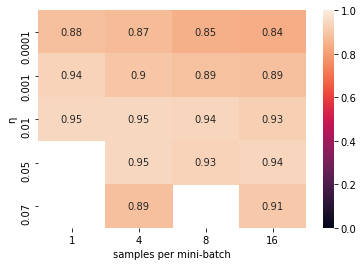

eta 0.0001
sam 4
0.0001

The R2 value for a polynomial of order 5, OLS train: 0.8682971539032852
The MSE value for a polynomial of order 5, OLS train: 0.010476518146561767
0.001

The R2 value for a polynomial of order 5, OLS train: 0.8695962303509535
The MSE value for a polynomial of order 5, OLS train: 0.010373180987334593
0.01

The R2 value for a polynomial of order 5, OLS train: 0.8670986423424691
The MSE value for a polynomial of order 5, OLS train: 0.010571855707502048
0.05

The R2 value for a polynomial of order 5, OLS train: 0.847526294503182
The MSE value for a polynomial of order 5, OLS train: 0.012128770105225346
0.07

The R2 value for a polynomial of order 5, OLS train: 0.8412830783131596
The MSE value for a polynomial of order 5, OLS train: 0.012625396940910019
eta 0.001
sam 4
0.0001

The R2 value for a polynomial of order 5, OLS train: 0.900134845359709
The MSE value for a polynomial of order 5, OLS train: 0.007943936944459872
0.001

The R2 value for a polynomial of order 

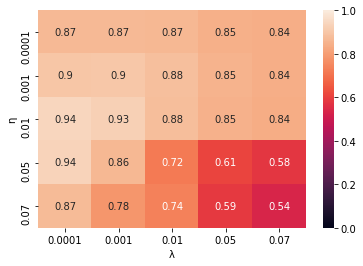

In [39]:
np.random.seed(26)

sig2 = 0#.01 # noise variance
degree = 5 # polynomial degree
n = 16 # number of data points for each feature

x1, x2, y = createDataPoints(n, sig2)
X = createDesignMatrix(x1,x2,degree)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)
X_train, X_test = Scale(X_train, X_test)
y_train = y_train[:, np.newaxis]

m = X_train.shape[0] # number of training examples
samPerMini = [4] # number of samples per mini-batch    
etas = [1E-4, 1E-3, 1E-2, 5E-2, 7E-2] # learning rates to use

n_epochs = 10000 # number of epochs
t0, t1 = 5, 50

lmbs = [0]
samPerMini = [1, 4, 8, 16] # number of samples per mini-batch    

_, yy = Regression("ols", X_train,X_test,y_train,y_test,n_epochs, samPerMini, etas, lmbs)

lmbs = [1E-4, 1E-3, 1E-2, 5E-2, 7E-2]   
samPerMini = [4] # number of samples per mini-batch    

_, yy = Regression("ridge", X_train,X_test,y_train,y_test,n_epochs, samPerMini, etas, lmbs)